# Graph Convolutional Network by Kipf and Welling

## Imports

In [3]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

import pickle
import numpy as np

import itertools

import performance as pf

from scipy.spatial import distance

## GNN Definition

In [4]:
class LinearModule(nn.Module):
    """The linear transformation part of the GCN layer"""
    def __init__(self, in_feats, out_feats, activation):
        super(LinearModule, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_feats, affine=False)
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation # This is the activation function

    def forward(self, node):
        h = self.bn1(node.data['h'])
        h = self.linear(h)
        h = self.activation(h)
        return {'h' : h}

In [5]:
class GCN(nn.Module):
    """A GCN layer"""
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = LinearModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(message_func=fn.copy_src(src='h', out='m'), reduce_func=fn.sum(msg='m', out='h'))
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [6]:
class Net(nn.Module):
    def __init__(self, infeats, hidden_size, outfeats):
        super(Net, self).__init__()
        self.gcn1 = GCN(infeats, hidden_size, F.relu)
        self.gcn2 = GCN(hidden_size, outfeats, F.relu)
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, g, features):
        x = self.gcn1(g, features)
        #x = self.dropout(x)
        x = self.gcn2(g, x)
        #x = F.log_softmax(x,1)
        return x

## Data Loading

In [7]:
from dgl.data import citation_graph as citegrh
import networkx as nx

data = citegrh.load_cora()
features = th.FloatTensor(data.features)
labels = th.LongTensor(data.labels)
mask = th.BoolTensor(data.train_mask)
g = data.graph

# add self loop
g.remove_edges_from(nx.selfloop_edges(g))
g = DGLGraph(g)
g.add_edges(g.nodes(), g.nodes())

In [19]:
labels_1hot = np.eye(np.max(labels.numpy()) + 1)[labels.numpy()]
labels_pair=th.FloatTensor(np.dot(labels_1hot,np.transpose(labels_1hot))).view(-1,1)
labels_pair.shape

torch.Size([7333264, 1])

### Define PairNet

In [8]:
pairg = g.to_networkx()
additional_edges = []
while len(additional_edges)<10000:
    e = (np.random.randint(0,pairg.number_of_nodes()),np.random.randint(0,pairg.number_of_nodes()))
    if not (e in pairg.edges): additional_edges.append(e)
pairg.add_edges_from(additional_edges)
pairsample = (th.LongTensor([i for (i,j) in pairg.edges()]),th.LongTensor([j for (i,j) in pairg.edges()]))
pairsample[0].shape

torch.Size([23257])

In [18]:
adj_index = th.Tensor(nx.to_numpy_matrix(pairg)).bool().view(-1)

In [10]:
class PairNet(nn.Module):
    def __init__(self, gcn_infeats, gcn_hidden_size, gcn_outfeats, ffn_hidden_size=20):
        super(PairNet, self).__init__()
        self.Net = Net(gcn_infeats, gcn_hidden_size, gcn_outfeats)
        self.linear = nn.Linear(gcn_outfeats*2, ffn_hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(ffn_hidden_size, 1) 

    def forward(self, g, features):
        x = self.Net(g, features)
        #x_rep = x.repeat_interleave(x.shape[0],dim=0)
        x_rep=th.index_select(x,dim=0,index=pairsample[0])
        #y_rep = x.repeat(x.shape[0],1)
        y_rep=th.index_select(x,dim=0,index=pairsample[1])
        comb = th.cat([x_rep,y_rep],dim=1)
        result = self.linear(comb)
        result = F.relu(result)
        result = self.dropout(result)
        result = self.linear2(result)
        return result

In [11]:
def pairall(thenet, g, features):
        sig = nn.Sigmoid()
        x = thenet.Net(g, features)
        x_rep = x.repeat_interleave(x.shape[0],dim=0)
        y_rep = x.repeat(x.shape[0],1)
        comb = th.cat([x_rep,y_rep],dim=1)
        result = thenet.linear(comb)
        result = F.relu(result)
        result = thenet.linear2(result)
        result = sig(result)
        return result

In [12]:
net = PairNet(features.shape[1], 21, 4)
pred = net(g, features)
pred.shape

torch.Size([23257, 1])

In [13]:
pred

tensor([[ 0.0994],
        [ 0.0736],
        [ 0.0272],
        ...,
        [-0.0041],
        [ 0.1464],
        [ 0.0218]], grad_fn=<AddmmBackward>)

## Select Training Set

In [13]:
percentage_train = 0.5

with open("data/cora_permutation1.pickle","rb") as f:
    perm1 = pickle.load(f)
mask = np.zeros(g.number_of_nodes())
mask[perm1[range(int(percentage_train*g.number_of_nodes()))]] = 1
mask = th.BoolTensor(mask)

In [27]:
features = g.in_degrees().float().unsqueeze(1)

In [84]:
features=th.cat([features,th.rand(size=(g.number_of_nodes(),1000))],1)

In [14]:
features=th.eye(g.number_of_nodes())

## Training

In [15]:
loss_function = nn.BCEWithLogitsLoss() #pf.perm_inv_loss(labels)

In [17]:
labels_pair[g.adjacency_matrix().to_dense().bool().view(-1),:].sum()/g.adjacency_matrix().to_dense().sum()

NameError: name 'labels_pair' is not defined

In [28]:
import time

net = PairNet(features.shape[1], 100, 100)
#print(net)

optimizer = th.optim.Adam(net.parameters(), lr=1e-2, weight_decay=0)
net.train() # Set to training mode (use dropout)

dur = []
loss_ev = []
for epoch in range(1800):
    if epoch >=3:
        t0 = time.time()

    # Compute loss for test nodes (only for validation, not used by optimizer)
    #net.eval()
    #prediction = net(g, features)
    #train_rand=pf.rand_score(labels[mask].numpy(),np.argmax(prediction[mask].detach().numpy(), axis=1))
    #validation_rand=pf.rand_score(labels[~mask].numpy(),np.argmax(prediction[~mask].detach().numpy(), axis=1))
    train_rand=0
    validation_rand=0
    #net.train()

    # Compute loss for train nodes
    prediction = net(g, features)

    #loss = loss_function.approximate_loss(logits,mask,nclasses=3)
    
    #loss = F.nll_loss(logits[mask], labels[mask])
    loss = loss_function(prediction,labels_pair[adj_index,:])
    loss_ev.append(loss.detach().item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) {np.mean(dur):.4f}")
    else:
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) unknown")

Epoch 00000 | Loss 0.7081 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) unknown
Epoch 00001 | Loss 0.7317 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) unknown
Epoch 00002 | Loss 0.6883 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) unknown
Epoch 00003 | Loss 0.6813 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2475
Epoch 00004 | Loss 0.6808 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2409
Epoch 00005 | Loss 0.6811 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2422
Epoch 00006 | Loss 0.6805 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2454
Epoch 00007 | Loss 0.6785 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2463
Epoch 00008 | Loss 0.6763 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2443
Epoch 00009 | Loss 0.6765 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2469
Epoch 00010 | Loss 0.6763 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2473
Epoch 00011 | Loss 0.6766 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2476
E

Epoch 00098 | Loss 0.6651 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2498
Epoch 00099 | Loss 0.6652 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2497
Epoch 00100 | Loss 0.6648 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2495
Epoch 00101 | Loss 0.6654 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2495
Epoch 00102 | Loss 0.6650 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2495
Epoch 00103 | Loss 0.6645 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2495
Epoch 00104 | Loss 0.6653 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2497
Epoch 00105 | Loss 0.6645 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2497
Epoch 00106 | Loss 0.6649 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2497
Epoch 00107 | Loss 0.6636 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2500
Epoch 00108 | Loss 0.6639 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2501
Epoch 00109 | Loss 0.6634 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2501
Epoc

Epoch 00196 | Loss 0.6615 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2594
Epoch 00197 | Loss 0.6625 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2604
Epoch 00198 | Loss 0.6613 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2612
Epoch 00199 | Loss 0.6617 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2620
Epoch 00200 | Loss 0.6620 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2623
Epoch 00201 | Loss 0.6620 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2628
Epoch 00202 | Loss 0.6597 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2635
Epoch 00203 | Loss 0.6600 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2642
Epoch 00204 | Loss 0.6607 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2649
Epoch 00205 | Loss 0.6598 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2654
Epoch 00206 | Loss 0.6599 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2661
Epoch 00207 | Loss 0.6613 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.2669
Epoc

Epoch 00294 | Loss 0.6551 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3032
Epoch 00295 | Loss 0.6557 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3035
Epoch 00296 | Loss 0.6555 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3039
Epoch 00297 | Loss 0.6561 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3043
Epoch 00298 | Loss 0.6566 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3047
Epoch 00299 | Loss 0.6550 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3051
Epoch 00300 | Loss 0.6552 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3055
Epoch 00301 | Loss 0.6549 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3056
Epoch 00302 | Loss 0.6551 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3057
Epoch 00303 | Loss 0.6552 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3057
Epoch 00304 | Loss 0.6548 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3060
Epoch 00305 | Loss 0.6545 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3063
Epoc

Epoch 00392 | Loss 0.6519 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3227
Epoch 00393 | Loss 0.6531 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3228
Epoch 00394 | Loss 0.6506 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3230
Epoch 00395 | Loss 0.6525 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3230
Epoch 00396 | Loss 0.6543 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3232
Epoch 00397 | Loss 0.6514 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3232
Epoch 00398 | Loss 0.6540 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3232
Epoch 00399 | Loss 0.6611 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3234
Epoch 00400 | Loss 0.6627 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3235
Epoch 00401 | Loss 0.6561 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3237
Epoch 00402 | Loss 0.6637 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3239
Epoch 00403 | Loss 0.6605 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3241
Epoc

Epoch 00490 | Loss 0.6553 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3256
Epoch 00491 | Loss 0.6526 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3255
Epoch 00492 | Loss 0.6522 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3254
Epoch 00493 | Loss 0.6540 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3253
Epoch 00494 | Loss 0.6515 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3252
Epoch 00495 | Loss 0.6514 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3250
Epoch 00496 | Loss 0.6511 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3249
Epoch 00497 | Loss 0.6493 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3248
Epoch 00498 | Loss 0.6504 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3247
Epoch 00499 | Loss 0.6478 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3246
Epoch 00500 | Loss 0.6482 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3245
Epoch 00501 | Loss 0.6499 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3244
Epoc

Epoch 00588 | Loss 0.6433 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3155
Epoch 00589 | Loss 0.6467 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3154
Epoch 00590 | Loss 0.6523 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3153
Epoch 00591 | Loss 0.6497 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3152
Epoch 00592 | Loss 0.6521 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3152
Epoch 00593 | Loss 0.6485 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3151
Epoch 00594 | Loss 0.6501 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3150
Epoch 00595 | Loss 0.6457 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3149
Epoch 00596 | Loss 0.6498 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3148
Epoch 00597 | Loss 0.6479 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3147
Epoch 00598 | Loss 0.6457 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 00599 | Loss 0.6501 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoc

Epoch 00686 | Loss 0.6447 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3091
Epoch 00687 | Loss 0.6458 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3091
Epoch 00688 | Loss 0.6456 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3090
Epoch 00689 | Loss 0.6445 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3090
Epoch 00690 | Loss 0.6432 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3089
Epoch 00691 | Loss 0.6429 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3088
Epoch 00692 | Loss 0.6428 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3088
Epoch 00693 | Loss 0.6420 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3088
Epoch 00694 | Loss 0.6428 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3087
Epoch 00695 | Loss 0.6415 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3086
Epoch 00696 | Loss 0.6424 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3086
Epoch 00697 | Loss 0.6408 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3086
Epoc

Epoch 00784 | Loss 0.6398 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3051
Epoch 00785 | Loss 0.6418 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3051
Epoch 00786 | Loss 0.6410 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3051
Epoch 00787 | Loss 0.6406 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3051
Epoch 00788 | Loss 0.6423 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3051
Epoch 00789 | Loss 0.6444 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3051
Epoch 00790 | Loss 0.6442 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3050
Epoch 00791 | Loss 0.6438 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3050
Epoch 00792 | Loss 0.6433 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3050
Epoch 00793 | Loss 0.6456 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3050
Epoch 00794 | Loss 0.6422 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3050
Epoch 00795 | Loss 0.6422 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3049
Epoc

Epoch 00882 | Loss 0.6398 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3035
Epoch 00883 | Loss 0.6391 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3035
Epoch 00884 | Loss 0.6393 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3035
Epoch 00885 | Loss 0.6399 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3035
Epoch 00886 | Loss 0.6374 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3035
Epoch 00887 | Loss 0.6405 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3034
Epoch 00888 | Loss 0.6397 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3034
Epoch 00889 | Loss 0.6401 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3034
Epoch 00890 | Loss 0.6393 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3034
Epoch 00891 | Loss 0.6374 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3034
Epoch 00892 | Loss 0.6387 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3033
Epoch 00893 | Loss 0.6382 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3033
Epoc

Epoch 00980 | Loss 0.6418 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3032
Epoch 00981 | Loss 0.6414 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3033
Epoch 00982 | Loss 0.6412 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3034
Epoch 00983 | Loss 0.6395 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3035
Epoch 00984 | Loss 0.6408 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3036
Epoch 00985 | Loss 0.6423 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3037
Epoch 00986 | Loss 0.6402 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3037
Epoch 00987 | Loss 0.6387 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3037
Epoch 00988 | Loss 0.6374 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3037
Epoch 00989 | Loss 0.6360 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3037
Epoch 00990 | Loss 0.6385 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3036
Epoch 00991 | Loss 0.6367 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3037
Epoc

Epoch 01078 | Loss 0.6416 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3040
Epoch 01079 | Loss 0.6419 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3040
Epoch 01080 | Loss 0.6409 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3040
Epoch 01081 | Loss 0.6416 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3040
Epoch 01082 | Loss 0.6399 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3039
Epoch 01083 | Loss 0.6403 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3039
Epoch 01084 | Loss 0.6405 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3039
Epoch 01085 | Loss 0.6397 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3039
Epoch 01086 | Loss 0.6382 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3039
Epoch 01087 | Loss 0.6379 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3039
Epoch 01088 | Loss 0.6394 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3039
Epoch 01089 | Loss 0.6378 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3039
Epoc

Epoch 01176 | Loss 0.6424 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01177 | Loss 0.6415 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01178 | Loss 0.6433 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01179 | Loss 0.6414 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01180 | Loss 0.6415 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01181 | Loss 0.6401 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01182 | Loss 0.6401 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01183 | Loss 0.6400 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01184 | Loss 0.6396 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01185 | Loss 0.6402 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01186 | Loss 0.6380 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoch 01187 | Loss 0.6406 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3028
Epoc

Epoch 01274 | Loss 0.6324 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3030
Epoch 01275 | Loss 0.6334 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3030
Epoch 01276 | Loss 0.6324 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3030
Epoch 01277 | Loss 0.6322 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3031
Epoch 01278 | Loss 0.6319 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3031
Epoch 01279 | Loss 0.6320 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3031
Epoch 01280 | Loss 0.6309 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3031
Epoch 01281 | Loss 0.6295 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3031
Epoch 01282 | Loss 0.6288 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3031
Epoch 01283 | Loss 0.6299 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3031
Epoch 01284 | Loss 0.6297 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3031
Epoch 01285 | Loss 0.6300 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3031
Epoc

Epoch 01372 | Loss 0.6358 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3049
Epoch 01373 | Loss 0.6353 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3050
Epoch 01374 | Loss 0.6346 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3050
Epoch 01375 | Loss 0.6351 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3050
Epoch 01376 | Loss 0.6335 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3051
Epoch 01377 | Loss 0.6351 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3052
Epoch 01378 | Loss 0.6355 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3052
Epoch 01379 | Loss 0.6344 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3053
Epoch 01380 | Loss 0.6350 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3053
Epoch 01381 | Loss 0.6338 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3054
Epoch 01382 | Loss 0.6331 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3055
Epoch 01383 | Loss 0.6314 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3055
Epoc

Epoch 01470 | Loss 0.6356 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3111
Epoch 01471 | Loss 0.6384 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3112
Epoch 01472 | Loss 0.6340 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3112
Epoch 01473 | Loss 0.6387 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3112
Epoch 01474 | Loss 0.6372 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3113
Epoch 01475 | Loss 0.6395 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3114
Epoch 01476 | Loss 0.6362 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3115
Epoch 01477 | Loss 0.6390 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3115
Epoch 01478 | Loss 0.6365 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3116
Epoch 01479 | Loss 0.6342 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3117
Epoch 01480 | Loss 0.6351 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3117
Epoch 01481 | Loss 0.6316 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3118
Epoc

Epoch 01568 | Loss 0.6242 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01569 | Loss 0.6234 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01570 | Loss 0.6239 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01571 | Loss 0.6255 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01572 | Loss 0.6230 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01573 | Loss 0.6236 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01574 | Loss 0.6249 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01575 | Loss 0.6234 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01576 | Loss 0.6247 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01577 | Loss 0.6263 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01578 | Loss 0.6252 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoch 01579 | Loss 0.6236 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3164
Epoc

Epoch 01666 | Loss 0.6367 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3159
Epoch 01667 | Loss 0.6397 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3159
Epoch 01668 | Loss 0.6362 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3159
Epoch 01669 | Loss 0.6389 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3159
Epoch 01670 | Loss 0.6388 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3158
Epoch 01671 | Loss 0.6398 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3159
Epoch 01672 | Loss 0.6372 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3159
Epoch 01673 | Loss 0.6385 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3159
Epoch 01674 | Loss 0.6373 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3159
Epoch 01675 | Loss 0.6363 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3158
Epoch 01676 | Loss 0.6354 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3158
Epoch 01677 | Loss 0.6341 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3158
Epoc

Epoch 01764 | Loss 0.6324 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3147
Epoch 01765 | Loss 0.6332 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3147
Epoch 01766 | Loss 0.6350 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 01767 | Loss 0.6318 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 01768 | Loss 0.6333 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 01769 | Loss 0.6330 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 01770 | Loss 0.6323 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 01771 | Loss 0.6342 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 01772 | Loss 0.6366 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 01773 | Loss 0.6384 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 01774 | Loss 0.6337 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3146
Epoch 01775 | Loss 0.6355 | Train.Rand 0.0000 | Valid.Rand 0.0000 | Time(s) 0.3145
Epoc

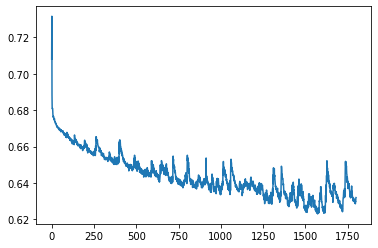

In [29]:
import seaborn as sns
sns.lineplot(x=range(len(loss_ev)), y=loss_ev)

In [30]:
from sklearn.metrics import accuracy_score
net.eval()
final_prediction = np.round(pairall(net, g, features).detach().view(g.number_of_nodes(),g.number_of_nodes()))
print(f"Loss on training data: {loss_function(net(g, features),labels_pair[adj_index,:]).item():.4f}")
print(f"Accuracy on all data: {accuracy_score(labels_pair, final_prediction.view(-1)):.4f}")
print(f"Percentage of links in complete graph. Predicted: {(final_prediction.sum()/(g.number_of_nodes()**2)).item():.4f} | Real: {(labels_pair.sum()/(g.number_of_nodes()**2)).item():.4f}")

Loss on training data: 0.6224
Accuracy on all data: 0.6496
Percentage of links in complete graph. Predicted: 0.2677 | Real: 0.1796


In [31]:
labels_pair[adj_index,:].sum()/labels_pair[adj_index,:].shape[0]

tensor(0.5574)

In [32]:
# Where are the mistakes?
final_prediction-labels_pair.reshape(g.number_of_nodes(),g.number_of_nodes())

tensor([[ 0.,  1.,  0.,  ...,  1.,  0., -1.],
        [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  1.,  0.,  ...,  1.,  0.,  0.],
        ...,
        [ 1.,  1.,  1.,  ...,  0.,  0.,  1.],
        [ 0.,  1.,  1.,  ...,  1., -1.,  1.],
        [ 0.,  0.,  0.,  ...,  1.,  0., -1.]])

In [33]:
final_prediction

tensor([[1., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [1., 0., 0.,  ..., 1., 0., 0.]])

In [127]:
final_prediction=labels_pair.view(2708,2708)

### Use connected components of similarity graph where bridgy links have been removed

In [34]:
def dissimmat(final_prediction):
    dissims = {(i,j): distance.jaccard(f1,f2) for i,f1 in enumerate(final_prediction) for j,f2 in enumerate(final_prediction) if j>=i}
    diss_matrix=np.array([[dissims[(i,j)] if (i,j) in dissims else dissims[(j,i)] for j in range(final_prediction.shape[0])] for i in range(final_prediction.shape[0])])
    return diss_matrix

In [35]:
dissmat = dissimmat(final_prediction)

In [145]:
compG = nx.from_numpy_matrix(dissmat<0.2,create_using=nx.Graph())
print(nx.number_connected_components(compG))

7


In [146]:
# Compute labels out of connected components
pred_labels = np.zeros(2708)
for i,c in enumerate(nx.connected_components(compG)):
    pred_labels[list(c)] = i

In [147]:
pf.rand_score(labels,pred_labels)

0.020572259069134742

In [142]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
check_symmetric(final_prediction)

False

## Evaluation

In [41]:
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(g, features).detach()
pf.performance_as_df(labels,final_prediction,mask)

,All,Train,Test
Rand-Index,0.779452,0.982582,0.596059
Mutual Information,0.749836,0.974923,0.592846
Variation of Information,0.906211,0.089857,1.474745


### old stuff

In [495]:
net.eval() # Set net to evaluation mode (deactivates dropout)
sigf = nn.Sigmoid()
#final_prediction = np.round(sigf(net(g, features)).detach())
# change shape
final_prediction = final_prediction.view(g.number_of_nodes(),g.number_of_nodes()).numpy()
#final_prediction = labels_pair.view(g.number_of_nodes(),g.number_of_nodes()).numpy()
#final_prediction = graphmatrix.view(g.number_of_nodes(),g.number_of_nodes()).numpy()
compG = nx.from_numpy_matrix(final_prediction,create_using=nx.Graph())

def neighborhood_overlap(g, u, v):
    n_common_nbrs = len(set(nx.common_neighbors(g, u, v)))
    n_join_nbrs = g.degree(u) + g.degree(v) - n_common_nbrs - 2
    return n_common_nbrs / n_join_nbrs

In [498]:
print(nx.number_connected_components(compG))
bridge_like = [(u,v) for (u,v) in compG.edges() if neighborhood_overlap(compG, u, v)<0.9]
print(bridge_like)
#compG.remove_edges_from(bridge_like)
#print(nx.number_connected_components(compG))

1


KeyboardInterrupt: 